# Learn Actor Crititc

In [ ]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt


import sys
sys.path.append("../Biodiffrl")


import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".60"

# Optionally, force JAX to preallocate memory.
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Setup environment variable for Nvidia GPU acceleration
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True'
)
backend = 'gpu'
# backend = 'METAL'
# backend = 'cpu'

import jax
from jax import numpy as jp

import optax


# Enable compliation catch
jax.config.update("jax_compilation_cache_dir", "./jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", 0)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 5)
# jax.config.update("jax_explain_cache_misses", True)

# Debug Nan
jax.config.update("jax_debug_nans", False)


# More legible printing from numpy.
jp.set_printoptions(precision=4, suppress=True, linewidth=100)

import mujoco
import mujoco.mjx as mjx
from mujoco.mjx._src import scan
from mujoco.mjx._src import types

# More legible printing from numpy.
np.set_printoptions(precision=4, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

device = jax.devices(backend=backend)[0]

model_path = '../model/inverted_pendulum.xml'

# Single step
mjx_step = jax.jit(mjx.step, backend=backend)



# mjx_multiple_steps = jax.jit(multiple_steps, backend=backend, )

## Load Model

In [ ]:
from mujoco.mjx._src.biomtu import acceleration_mtu

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
# mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
# mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
# mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
mjx_data = mjx_step(mjx_model, mjx_data)

## Control Neural Network and Critic Neural Network
For now this NN will only work for the inverted pendulum

In [ ]:
import nn

key = jax.random.key(2024)
# Controller NN
controller_nn = nn.Controller_NN(mjx_model.nq*2, 1)
controller_params, key = controller_nn.init_parameters(key)
controller = controller_nn.get_fn()

# Critic NN
critic_nn = nn.Critic_NN(mjx_model.nq*2,1)
critic_params, key = critic_nn.init_parameters(key)
criticer = critic_nn.get_fn()

# Test the two neural networks
print(controller(controller_params, jp.ones(mjx_model.nq*2), key))
print(criticer(critic_params, jp.ones(mjx_model.nq*2)))

## Environment Control 

In [ ]:
# @jax.jit
def reset(model, batch_size):
    batch_dummy = jp.zeros(batch_size)
    v_make_data = jax.jit(jax.vmap(lambda model, batch_dummy: mjx.make_data(model), in_axes=(None,0),out_axes=0))
    new_datas = v_make_data(model, batch_dummy)
    return new_datas
    

## Multi-steps forward simulation

In [ ]:
import exp

def step_fn(carry, _):
    data, model = carry
    new_data = mjx.step(model, data)
    new_carry = (new_data, model)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (data, model)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=10)
    new_data = y[0]
    return new_data

def nn_mjx_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel])
    act, mean, dev = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(ctrl = jp.array(act))
    new_data = mjx.step(model, data)
    return new_data, new_key, act

@jax.jit
def jit_nn_mjx_one_step_no_random(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel])
    act, mean, dev = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(ctrl = jp.array(mean))
    new_data = mjx.step(model, data)
    return new_data, new_key, mean

def nn_step_fn(carry, _):
    nn_params, model, data, key = carry
    new_data, new_key, act = nn_mjx_one_step(nn_params, model, data, key)
    new_carry = (nn_params, model, new_data, new_key)
    # Calculate reward
    state = jp.stack([data.qpos, data.qvel], axis=1).flatten()
    next_state = jp.stack([new_data.qpos, data.qvel], axis=1).flatten()
    action = act
    reward = -new_data.qpos[1]**2
    experience = exp.experience(state, next_state, action, reward)
    
    return new_carry, experience

def decay_sum_scan(x, decay):
    def f(sxtm1, xt):
        b = xt + decay * sxtm1
        return b, b
    return jax.lax.scan(f, jp.zeros(x.shape[1:]), x)[1]

@jax.jit
def jit_nn_multi_steps(nn_params, model, data, key):
    repeat_length = 10
    init_carry = (nn_params, model, data, key)
    y, experience = jax.lax.scan(nn_step_fn, init_carry, None, length=repeat_length)
    new_data = y[2]
    new_key = y[3]
    
    return new_data, new_key, experience

@jax.jit
def jit_v_nn_multi_steps(nn_params, model, data, key):
    return jax.vmap(jit_nn_multi_steps, in_axes=(None, None, 0, 0))(nn_params, model, data, key)

# This function generate
@jax.jit
def jit_vv_nn_multi_steps(nn_params, model, data, key):
    return jax.vmap(jit_v_nn_multi_steps, in_axes=(None, None, None, 1))(nn_params, model, data, key)

## Calculate the critic loss and at the same time generate experience

In [ ]:
# Settings
import exp

batch_size = 400
key = jax.random.key(2024)
keys = jax.random.split(key, batch_size)
datas = reset(mjx_model,batch_size)

memory_settings = exp.memory_settings(batch_size*200, 4, 1, 1)
exp_pool = None

### Generate initial experience

In [ ]:
datas = reset(mjx_model,batch_size)
for i in range(5):    # For 2 seconds
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)
    
#plot exp_pool
plt.plot(exp_pool.states.T[1])
plt.plot(exp_pool.rewards)

### Function to calculate the criticer's gradient

In [ ]:
v_criticer = jax.vmap(criticer,in_axes=(None, 0))

def critic_loss(params, batch):
    discount = 0.95
    states = batch.states
    next_states = batch.next_states
    actions = batch.actions
    rewards = batch.rewards
    
    critic_score = v_criticer(params, states)
    target = rewards + discount* v_criticer(params, next_states)
    
    loss = optax.l2_loss(critic_score, target)
    loss = jp.mean(loss)
    return loss

sample_batch = exp.memory.sample(exp_pool, batch_size, key)
critic_loss_g_value_lower= jax.jit(jax.value_and_grad(critic_loss)).lower(critic_params, sample_batch)

jit_critic_loss_g_value = critic_loss_g_value_lower.compile()
a=jit_critic_loss_g_value.cost_analysis()[0]['flops']
print(a)

### Function to get controller gradient and generate experience

In [ ]:
def loss_and_experience(controller_params, critic_params, exps, batch_size, mjx_model, keys):
    states = exps.states
    # Generate data for simulation
    in_data = reset(mjx_model, batch_size).replace(qpos = states[:,0:2], qvel = states[:,2:4])
    out_data, keys, new_exps = jit_v_nn_multi_steps(controller_params, mjx_model, in_data, keys)
    out_states = jp.stack([out_data.qpos, out_data.qvel], axis=1).reshape(batch_size,4)
    # jax.debug.print("out_states shape{0}", out_states.shape)
    critic_score = v_criticer(critic_params, out_states)
    
    loss = -jp.mean(critic_score)
    return loss, new_exps

# The function calculating the loss of the controller and also generate experiences
g_loss_experience = jax.value_and_grad(loss_and_experience, has_aux=True)

sample_batch = exp.memory.sample(exp_pool, batch_size, key)
g_loss_experience_lower = jax.jit(g_loss_experience, static_argnames=["batch_size"]).lower(controller_params, critic_params, sample_batch, batch_size, mjx_model, keys)
jit_g_loss_experience = g_loss_experience_lower.compile()

b = jit_g_loss_experience.cost_analysis()[0]['flops']
print(b)
# exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)

In [ ]:
b/a

## Train the two neural networks


In [ ]:
critic_params, key = critic_nn.init_parameters(key)
critic_tx = optax.apply_if_finite(optax.adam(learning_rate=5e-5), max_consecutive_errors=20)
critic_opt_state = critic_tx.init(critic_params)
jit_critic_tx_update = jax.jit(critic_tx.update)


controller_params, key = controller_nn.init_parameters(key)
controller_tx = optax.apply_if_finite(optax.adam(learning_rate=3e-5), max_consecutive_errors=20)
controller_opt_state = controller_tx.init(controller_params)
jit_controller_tx_update = jax.jit(controller_tx.update)

jit_apply_update = jax.jit(optax.apply_updates)

# Init exp_pool
exp_pool = None
datas = reset(mjx_model,batch_size)
for i in range(3):    # For 2 seconds
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)


---------- 0 ----------
criticer loss: 0.00045554093
Controller Loss: 0.842847
---------- 1 ----------
criticer loss: 0.0001580821
Controller Loss: 0.6636816
---------- 2 ----------
criticer loss: 2.475653e-05
Controller Loss: 0.35939407
---------- 3 ----------
criticer loss: 8.1562815e-05
Controller Loss: 0.58383775
---------- 4 ----------
criticer loss: 3.980724e-05
Controller Loss: 0.25742918
---------- 5 ----------
criticer loss: 8.604833e-05
Controller Loss: 0.23743235
---------- 6 ----------
criticer loss: 0.000117919946
Controller Loss: 0.5128531
---------- 7 ----------
criticer loss: 7.6186343e-06
Controller Loss: 0.28693157
---------- 8 ----------
criticer loss: 0.000102538725
Controller Loss: 0.25936493
---------- 9 ----------
criticer loss: 6.910186e-05
Controller Loss: 0.6229811
---------- 10 ----------
criticer loss: 5.3450043e-05
Controller Loss: 0.4906961
---------- 11 ----------
criticer loss: 1.594123e-05
Controller Loss: 0.3828186
---------- 12 ----------
criticer los

/tmp/ipykernel_352247/1539056186.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


---------- 401 ----------
criticer loss: 0.0003029257
Controller Loss: 0.48707035
---------- 402 ----------
criticer loss: 7.355148e-05
Controller Loss: 0.7172032
---------- 403 ----------
criticer loss: 0.00046882863
Controller Loss: 0.51007885
---------- 404 ----------
criticer loss: 0.0005315794
Controller Loss: 1.3499322
---------- 405 ----------
criticer loss: 0.00044818158
Controller Loss: 1.3414756
---------- 406 ----------
criticer loss: 0.0001173599
Controller Loss: 0.77705055
---------- 407 ----------
criticer loss: 0.00013665172
Controller Loss: 0.5949369
---------- 408 ----------
criticer loss: 0.00031019692
Controller Loss: 1.3299042
---------- 409 ----------
criticer loss: 0.00016454507
Controller Loss: 0.9498921
---------- 410 ----------
criticer loss: 0.00022139541
Controller Loss: 1.2201009
---------- 411 ----------
criticer loss: 0.00046966094
Controller Loss: 0.76923794
---------- 412 ----------
criticer loss: 0.0002228329
Controller Loss: 0.5701058
---------- 413 --

KeyboardInterrupt: 

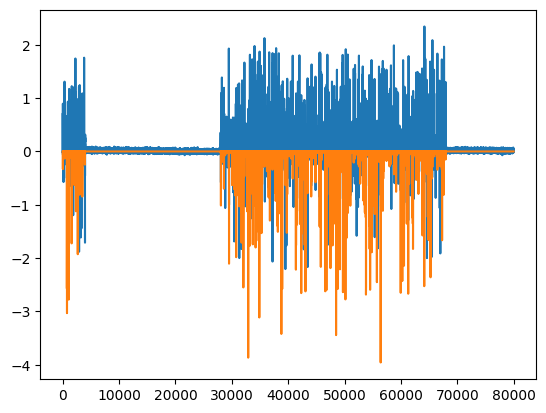

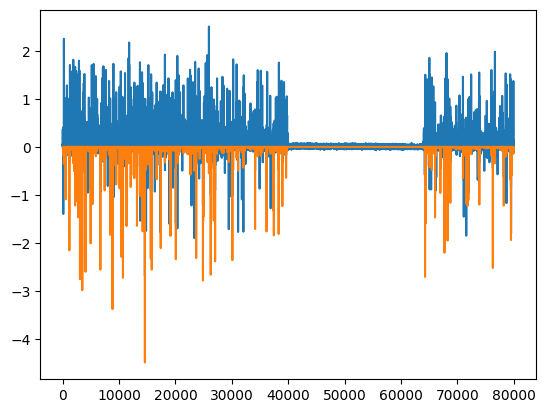

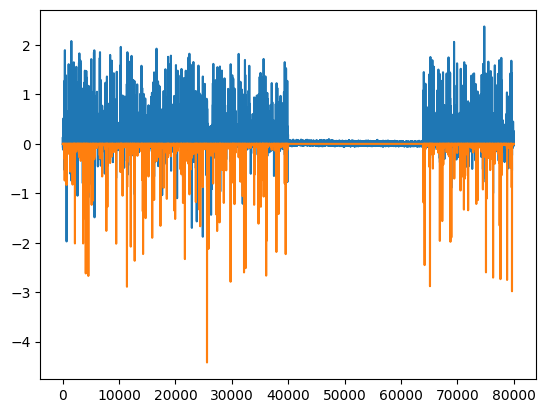

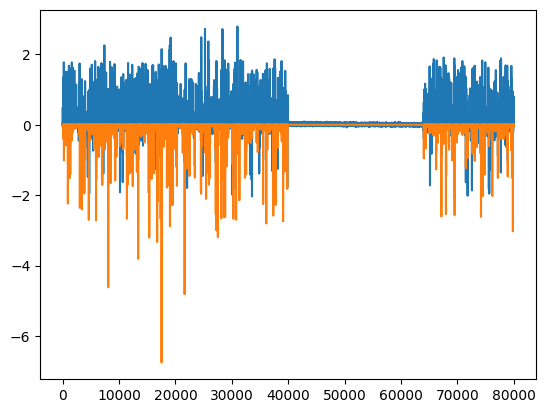

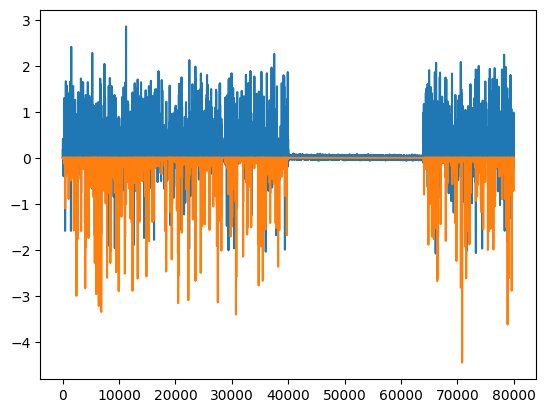

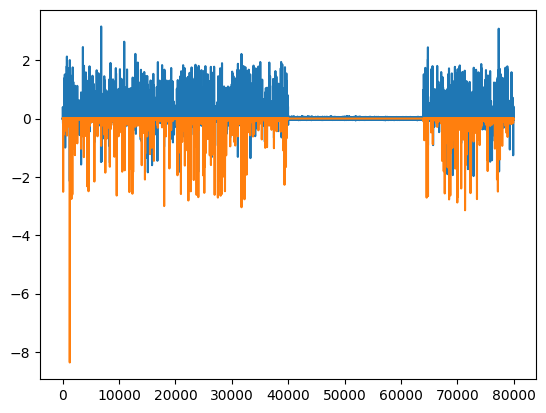

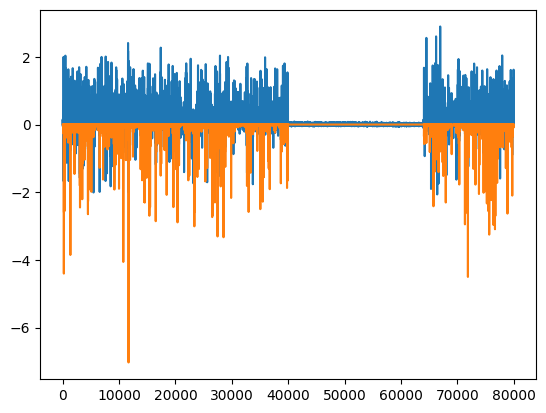

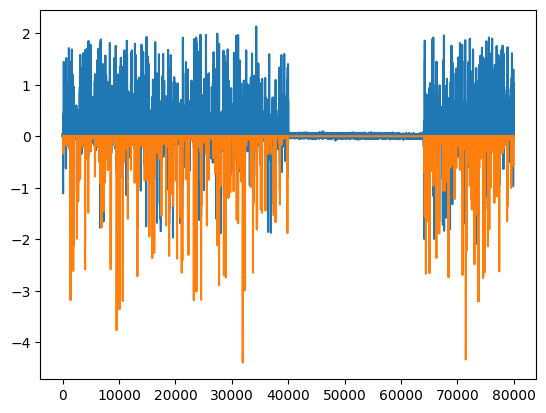

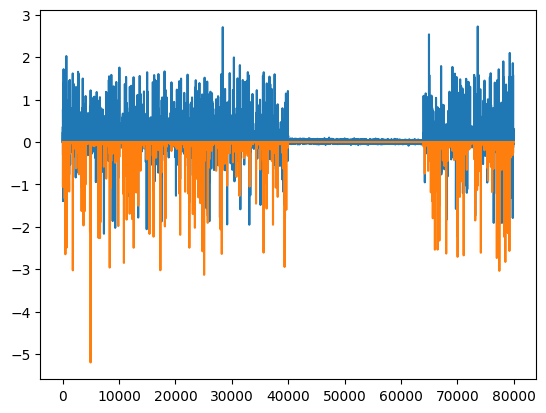

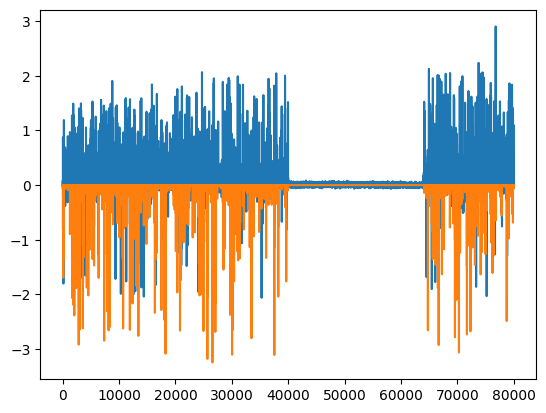

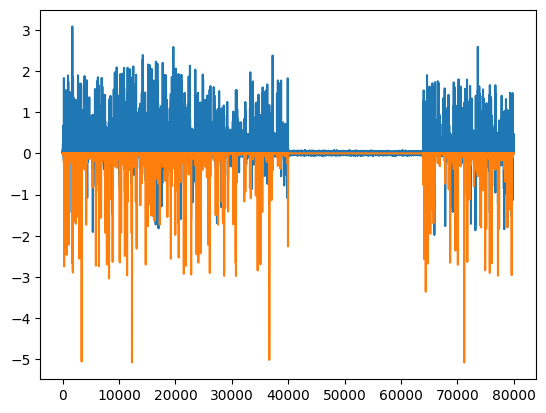

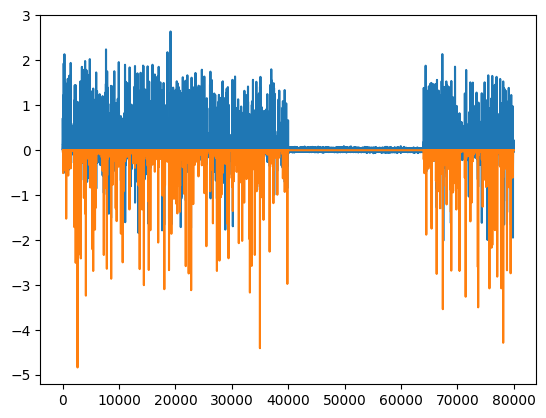

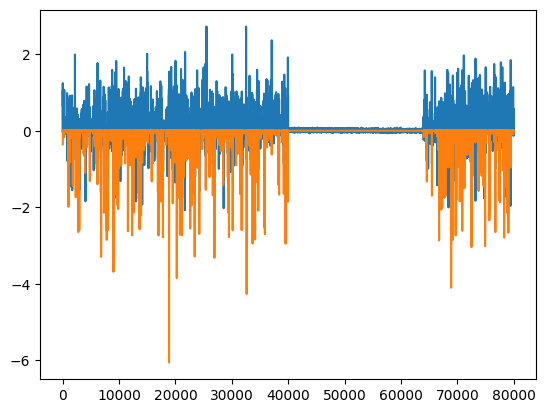

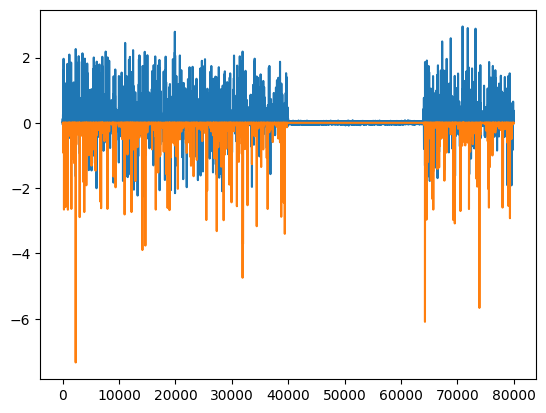

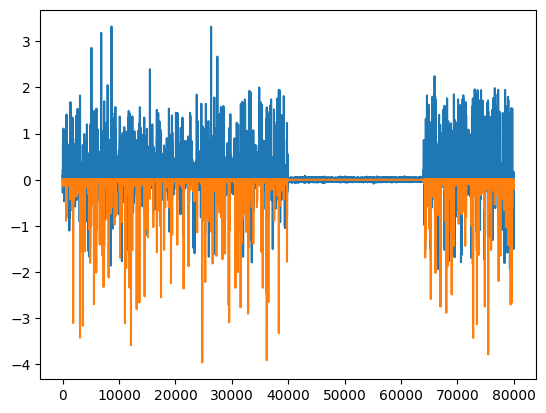

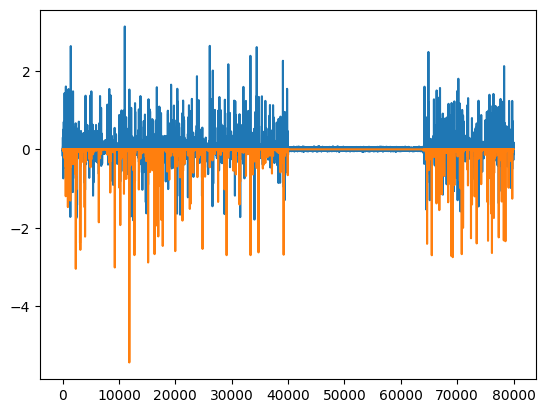

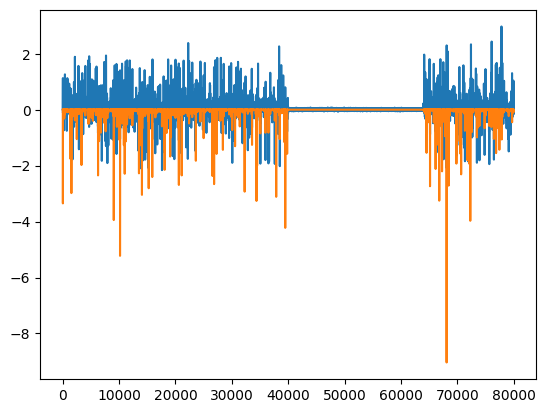

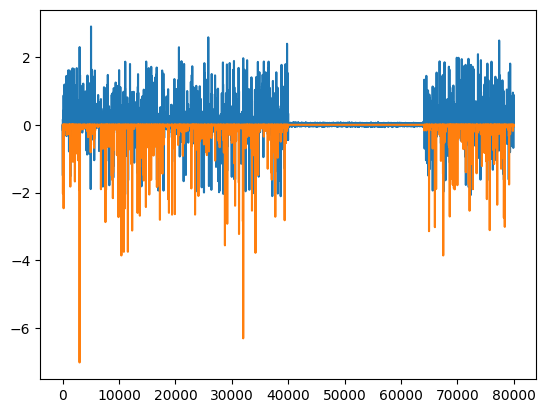

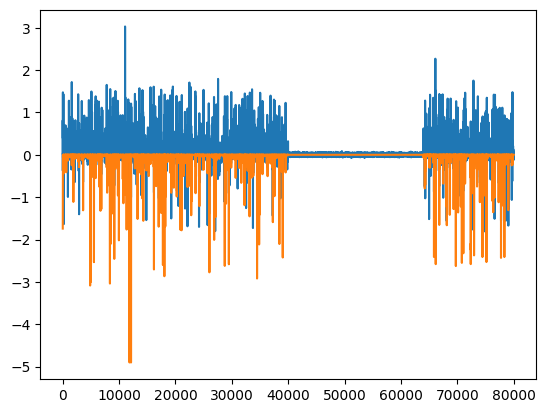

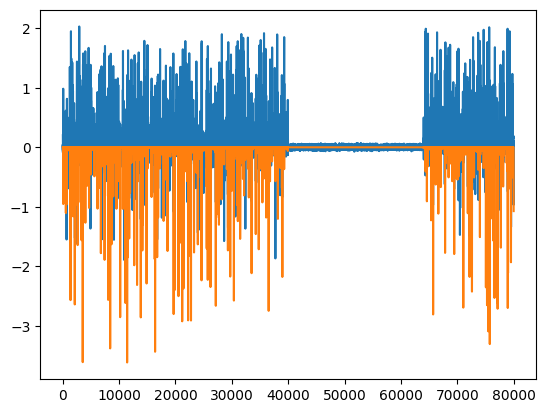

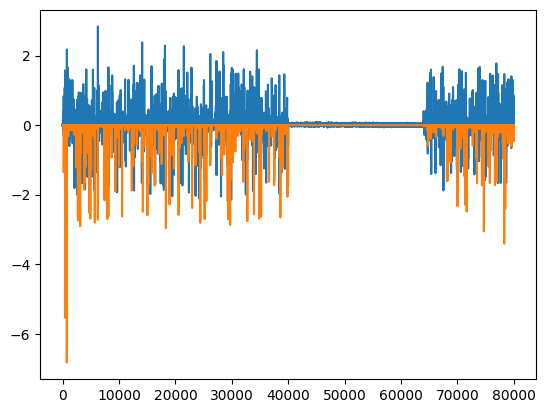

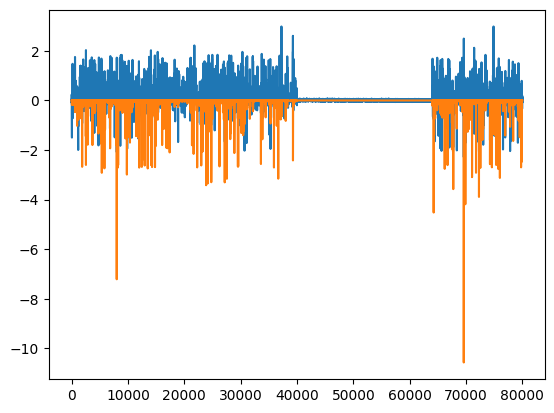

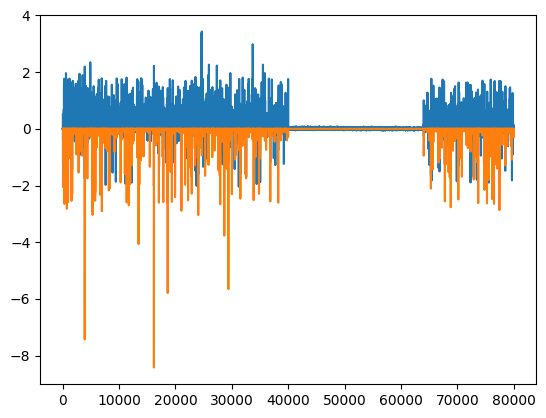

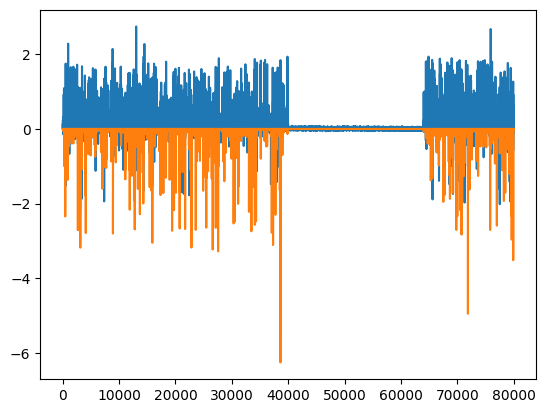

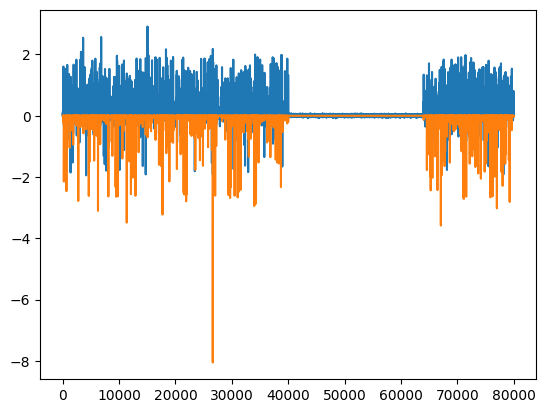

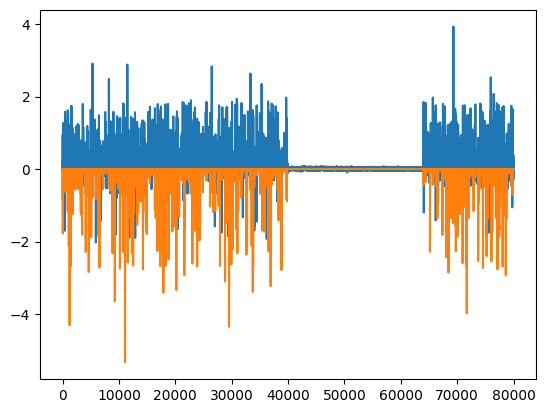

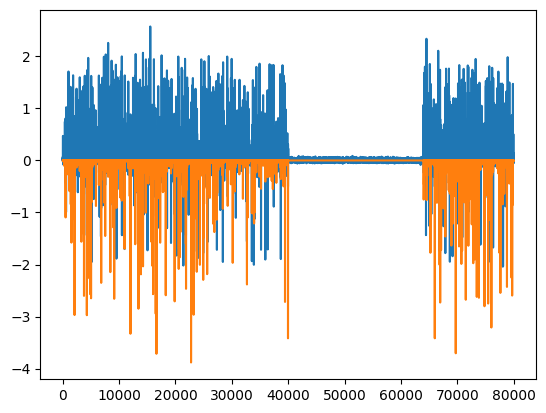

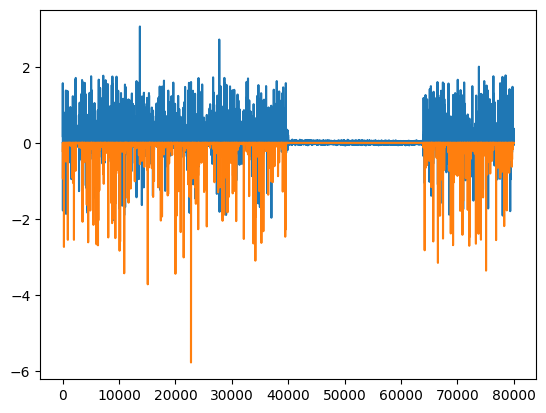

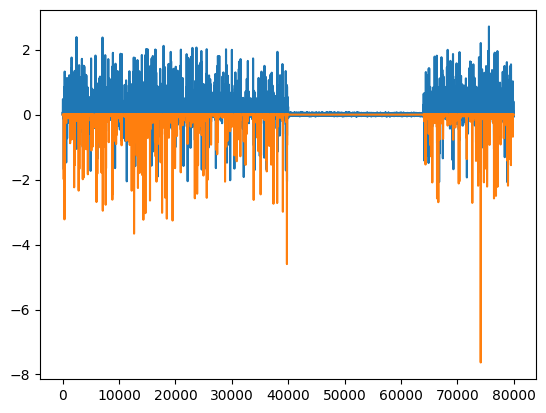

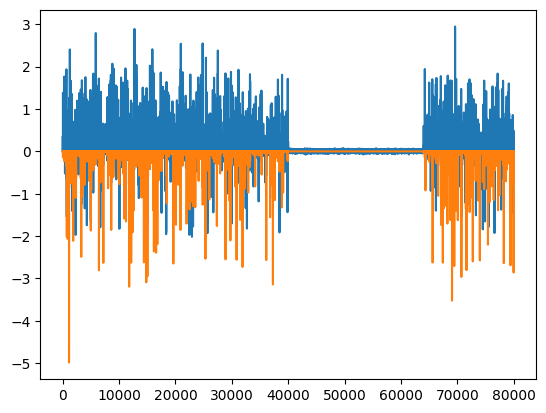

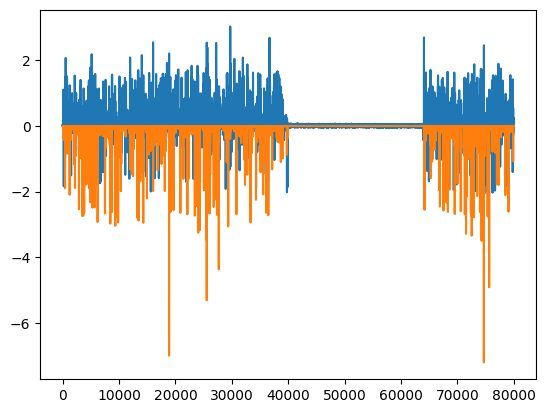

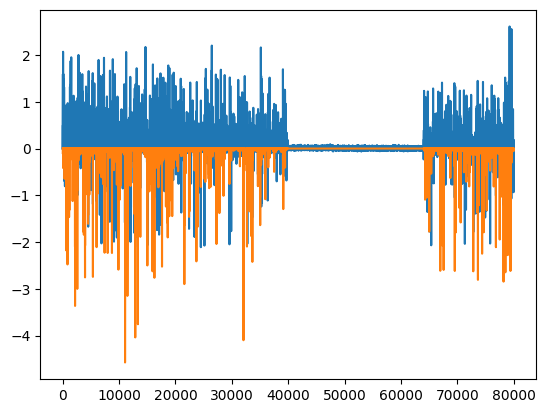

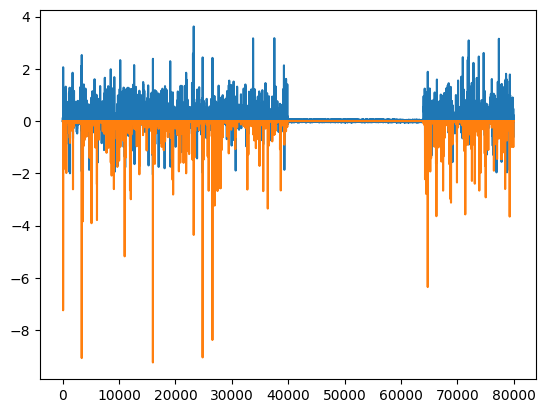

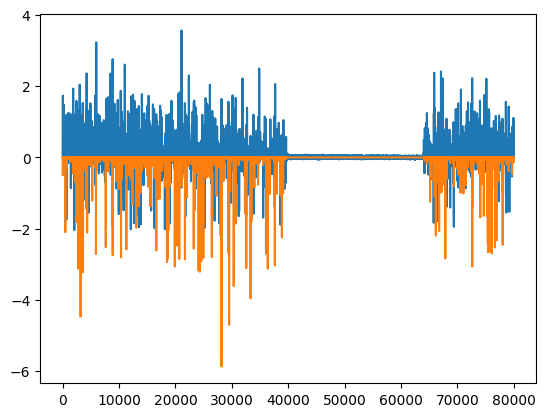

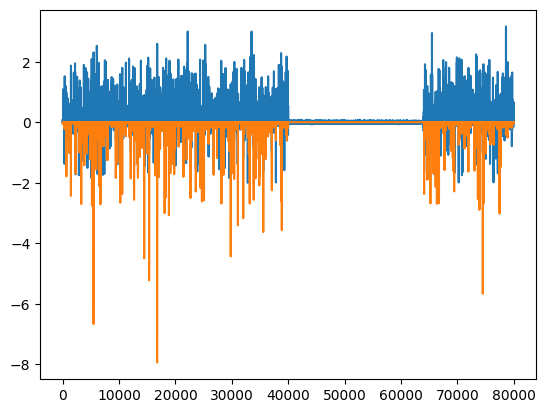

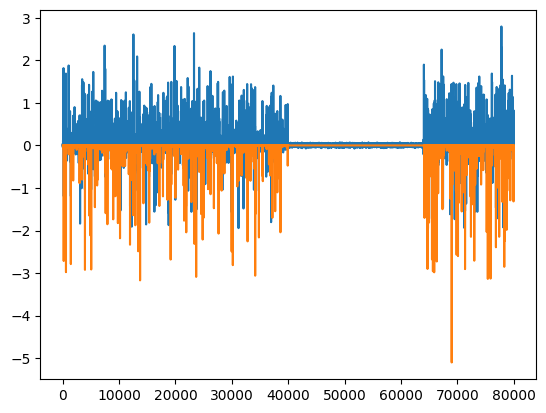

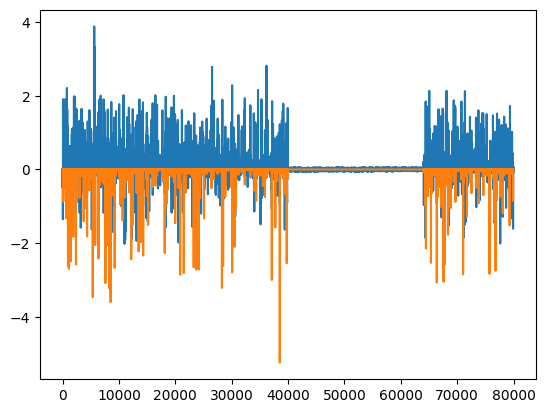

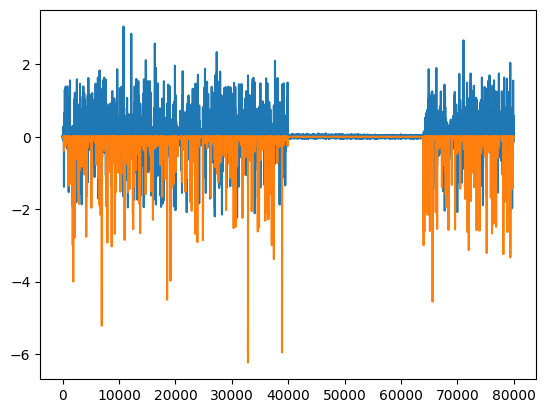

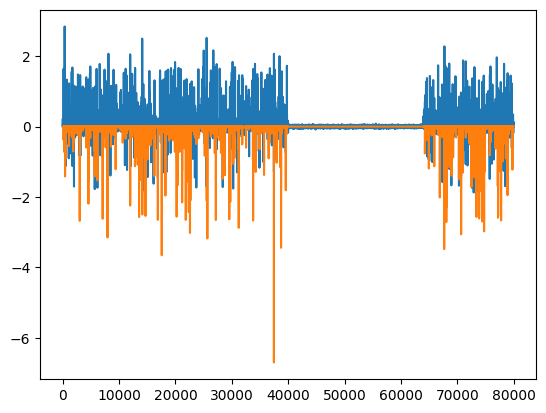

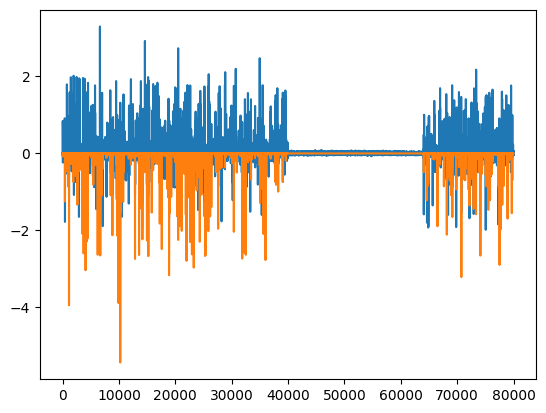

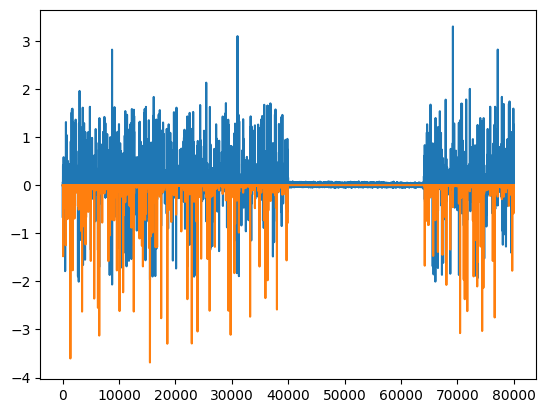

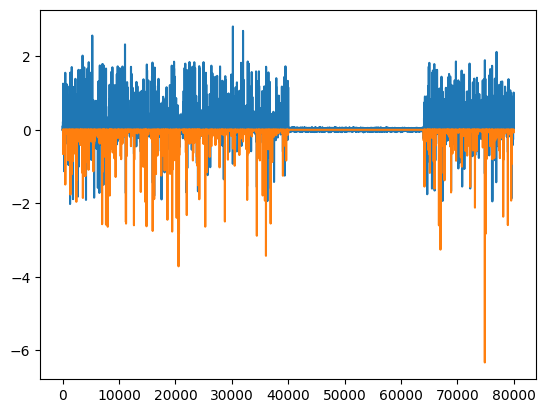

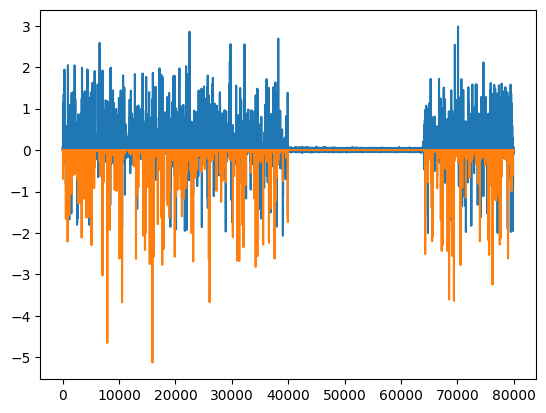

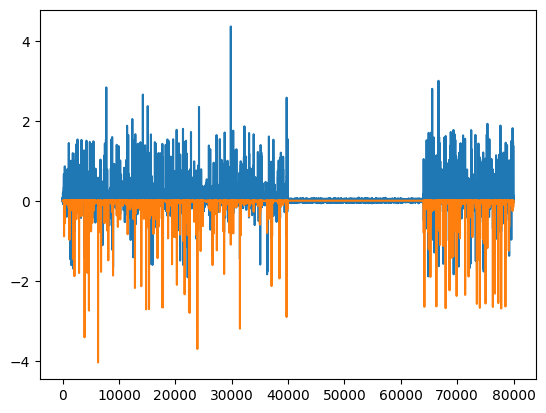

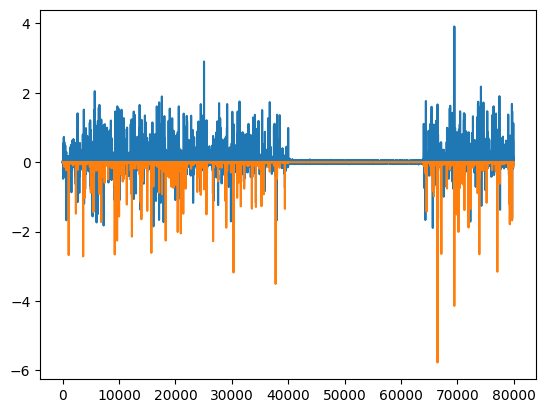

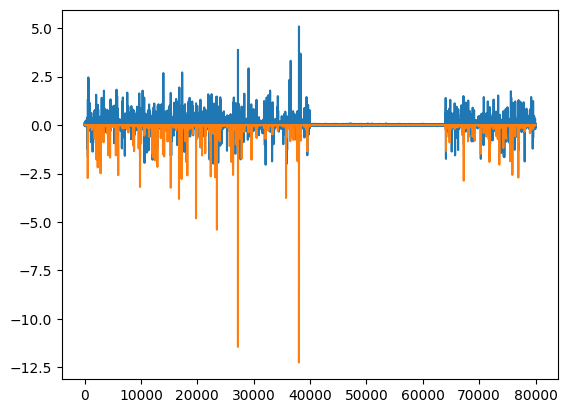

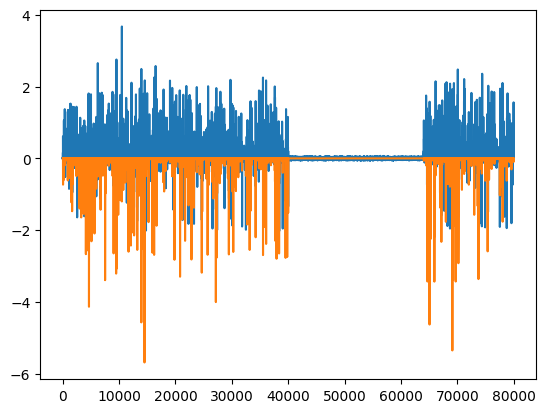

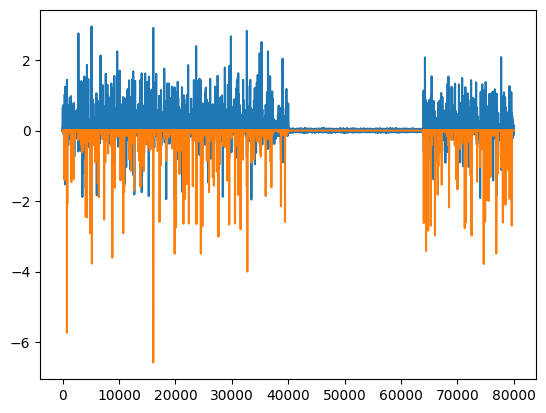

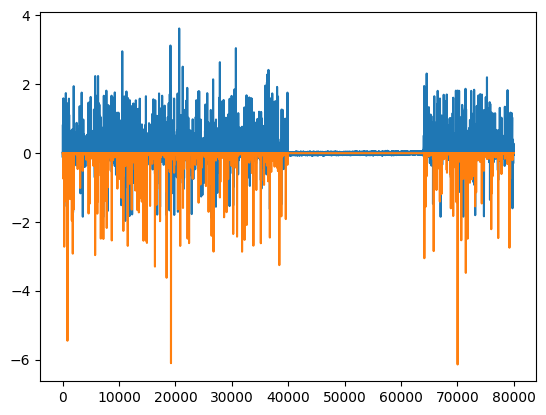

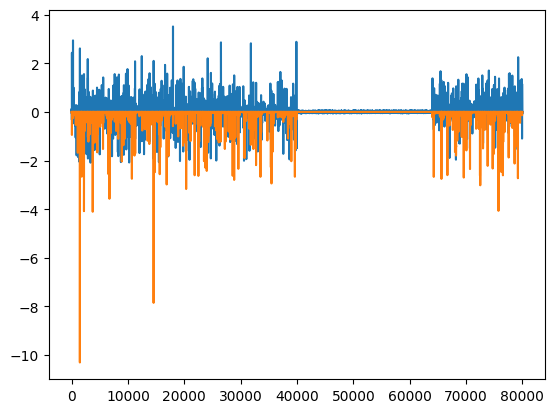

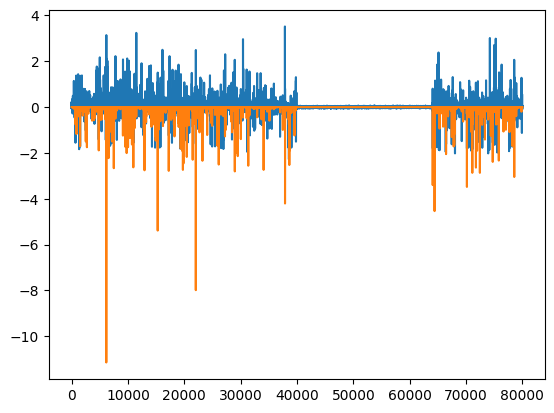

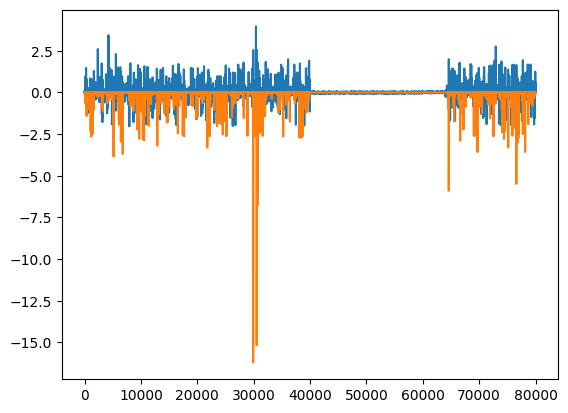

In [17]:


key = jax.random.key(345)

for i in range(2000):

    print("----------",i,"----------")
    batch = exp.memory.sample(exp_pool, batch_size, key)
    key = jax.random.split(key, 1)[0]
    
    # criticer
    critic_loss, critic_loss_grad = jit_critic_loss_g_value(critic_params, batch)
    print("criticer loss:",critic_loss)
    
    # Update params
    critic_updates, critic_opt_state = jit_critic_tx_update(critic_loss_grad, critic_opt_state)
    new_critic_params = jit_apply_update(critic_params, critic_updates)
    
    # controller
    keys = jax.random.split(key,batch_size)
    controller_loss_exps, controller_loss_grad = jit_g_loss_experience(controller_params, critic_params, batch, mjx_model, keys)
    controller_loss = controller_loss_exps[0]
    exps = controller_loss_exps[1]
    print("Controller Loss:", controller_loss)
        
    # Update params
    controller_updates, controller_opt_state = jit_controller_tx_update(controller_loss_grad, controller_opt_state)
    new_controller_params = jit_apply_update(controller_params, controller_updates)
    
    old_controller_loss_grad = controller_loss_grad
    critic_params = new_critic_params
    controller_params = new_controller_params
    # add exps
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)
    
    
    if(i%20 == 0):
        plt.figure()
        plt.plot(exp_pool.states.T[1])
        plt.plot(exp_pool.rewards)
        
    if(i%10 ==0):
        datas = reset(mjx_model,batch_size)
        for i in range(6):    # For 2 seconds
            datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
            exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)    

## Visualize the model and controller

In [18]:
import mujoco.viewer
import time


mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)
previous_frame_time = time.time()
i = 0
key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        # Generate key
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied, dtype=jp.float32))
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        key = jax.random.split(key,1)[0]
        # mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data, loss, exp = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mjx_data.sensordata)
        # print(len(mjx_data.qvel))
        viewer.sync()

Time between frames: 0.2284538745880127 seconds
Time between frames: 0.012215375900268555 seconds
Time between frames: 0.010161399841308594 seconds
Time between frames: 0.010981559753417969 seconds
Time between frames: 0.010075092315673828 seconds
Time between frames: 0.011138439178466797 seconds
Time between frames: 0.012067079544067383 seconds
Time between frames: 0.010114669799804688 seconds
Time between frames: 0.010754585266113281 seconds
Time between frames: 0.00964498519897461 seconds
Time between frames: 0.0063855648040771484 seconds
Time between frames: 0.006060361862182617 seconds
Time between frames: 0.009341716766357422 seconds
Time between frames: 0.006444692611694336 seconds
Time between frames: 0.005841732025146484 seconds
Time between frames: 0.006946086883544922 seconds
Time between frames: 0.008324384689331055 seconds
Time between frames: 0.007569789886474609 seconds
Time between frames: 0.005376100540161133 seconds
Time between frames: 0.005304813385009766 seconds
Ti

KeyboardInterrupt: 